In [1]:
%load_ext autoreload

In [55]:
%autoreload 2

from delase import DeLASE
from delase.dmd import embed_signal_torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from sklearn.decomposition import PCA

In [3]:
data = pd.read_pickle('/home/adameisen/Documents/data/ChaoticConsciousness/data_for_sarthak.pkl')

In [4]:
lfp_w = data["wake_lfps"]
lfp_a = data["anesthesia_lfps"]

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [6]:
min_freq = 4
max_freq = 300

lfp_wf = np.zeros(lfp_w.shape)
for i in range(lfp_w.shape[1]):
    lfp_wf[:, i] = butter_bandpass_filter(lfp_w[:, i], min_freq, max_freq, 1000, order=2)
lfp_af = np.zeros(lfp_a.shape)
for i in range(lfp_a.shape[1]):
    lfp_af[:, i] = butter_bandpass_filter(lfp_a[:, i], min_freq, max_freq, 1000, order=2)


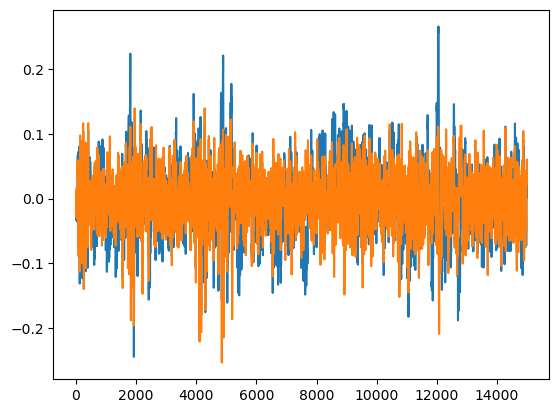

In [7]:
plt.plot(lfp_w[:, 0])
plt.plot(lfp_wf[:, 0])

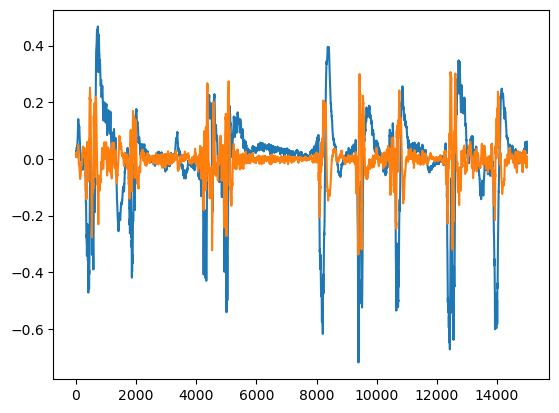

In [8]:
plt.plot(lfp_a[:, 0])
plt.plot(lfp_af[:, 0])



In [9]:
delase_w = DeLASE(lfp_w, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_wf = DeLASE(lfp_wf, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_a = DeLASE(lfp_a, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_af = DeLASE(lfp_af, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)  

In [10]:
delase_w.fit()
delase_wf.fit()
delase_a.fit()
delase_af.fit()

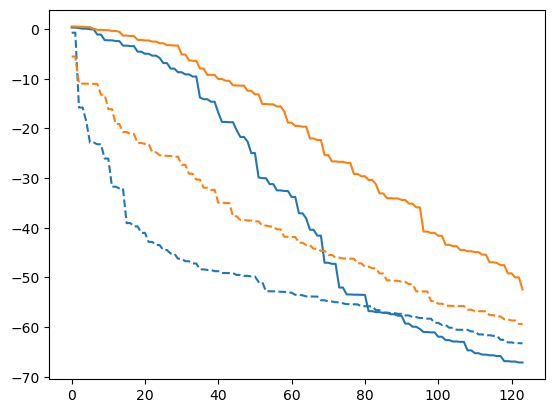

In [11]:
plt.plot(delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))])
plt.plot(delase_wf.stability_params.cpu()[:int(0.1*len(delase_wf.stability_params))], c='C0', linestyle='--')
plt.plot(delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))])
plt.plot(delase_af.stability_params.cpu()[:int(0.1*len(delase_af.stability_params))], c='C1', linestyle='--')
plt.show()

In [13]:
delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))].mean(), delase_wf.stability_params.cpu()[:int(0.1*len(delase_wf.stability_params))].mean(), delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))].mean(), delase_af.stability_params.cpu()[:int(0.1*len(delase_af.stability_params))].mean()

(tensor(-35.1341), tensor(-49.7109), tensor(-21.4567), tensor(-39.5783))

In [14]:
delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))].mean()

tensor(-21.4567)

In [15]:
delase_wf.stability_params.cpu()[:int(0.1*len(delase_wf.stability_params))].mean()

tensor(-49.7109)

In [16]:
delase_af.stability_params.cpu()[:int(0.1*len(delase_af.stability_params))].mean()

tensor(-39.5783)

In [54]:
min_freq = 0.1
max_freq = 4

lfp_ws = np.zeros(lfp_w.shape)
lfp_as = np.zeros(lfp_a.shape)

for i in range(lfp_a.shape[1]):
    fft_result_w = np.fft.rfft(lfp_w[:, i])
    magnitude_w = np.abs(fft_result_w)
    phase_w = np.angle(fft_result_w)

    fft_result_a = np.fft.rfft(lfp_a[:, i])
    freqs = np.fft.rfftfreq(lfp_a.shape[0], 0.001)
    magnitude_a = np.abs(fft_result_a)
    phase_a = np.angle(fft_result_a)
    
    freq_inds = (freqs > min_freq) & (freqs < max_freq)

    phase_a_temp = phase_a[freq_inds].copy()
    phase_a[freq_inds] = phase_w[freq_inds]
    phase_w[freq_inds] = phase_a_temp
    # phase_a[freq_inds] = np.random.uniform(0, 2*np.pi, sum(freq_inds))
    # phase_a[freq_inds] = 0
    lfp_ws[:, i] = np.fft.irfft(magnitude_w * np.exp(1j * phase_w))
    lfp_as[:, i] = np.fft.irfft(magnitude_a * np.exp(1j * phase_a))

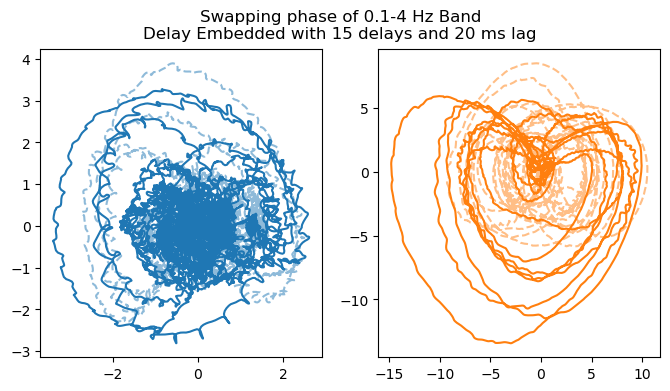

In [65]:
pca = PCA(n_components=2)
n_delays = 15
delay_interval = 20
lfp_w_pca = pca.fit_transform(embed_signal_torch(lfp_w, n_delays, delay_interval))
lfp_ws_pca = pca.fit_transform(embed_signal_torch(lfp_ws, n_delays, delay_interval))
lfp_a_pca = pca.fit_transform(embed_signal_torch(lfp_a, n_delays, delay_interval))
lfp_as_pca = pca.fit_transform(embed_signal_torch(lfp_as, n_delays, delay_interval))
plt.figure(figsize=(8, 4))
plt.suptitle('Swapping phase of {}-{} Hz Band\nDelay Embedded with {} delays and {} ms lag'.format(min_freq, max_freq, n_delays, delay_interval))

plt.subplot(1, 2, 1)
plt.plot(lfp_w_pca[:, 0], lfp_w_pca[:, 1])
plt.plot(lfp_ws_pca[:, 0], lfp_ws_pca[:, 1], c='C0', alpha=0.5, linestyle='--')
plt.subplot(1, 2, 2)
plt.plot(lfp_a_pca[:, 0], lfp_a_pca[:, 1], c='C1')
plt.plot(lfp_as_pca[:, 0], lfp_as_pca[:, 1], c='C1', alpha = 0.5, linestyle='--')
plt.show()


In [63]:
delase_ws = DeLASE(lfp_ws, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_ws.fit()
delase_as = DeLASE(lfp_as, n_delays=4, rank=1000, dt=0.001, device='cuda', max_freq=500, max_unstable_freq=500)
delase_as.fit()

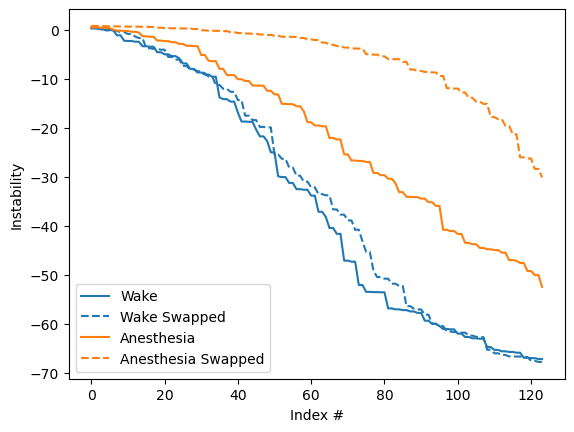

In [64]:
plt.plot(delase_w.stability_params.cpu()[:int(0.1*len(delase_w.stability_params))], label='Wake')
plt.plot(delase_ws.stability_params.cpu()[:int(0.1*len(delase_ws.stability_params))], c='C0', linestyle='--', label='Wake Swapped')
plt.plot(delase_a.stability_params.cpu()[:int(0.1*len(delase_a.stability_params))], c='C1', label='Anesthesia')
plt.plot(delase_as.stability_params.cpu()[:int(0.1*len(delase_as.stability_params))], c='C1', linestyle='--', label='Anesthesia Swapped')
plt.xlabel('Index #')
plt.ylabel('Instability')
plt.legend()
plt.show()